## ** New York City - East River Bicycle Crossings**##


*   In this dataset, how many bicycles cross into and out of Manhattan per day?
*   How strongly do weather conditions affect bike volumes?
*   What is the top bridge in terms of bike load?



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
import plotly.graph_objects as go
from plotly.offline import iplot
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

import matplotlib.pyplot as plt

from datetime import datetime
import datetime

from pandas_profiling import ProfileReport

# Reading and data cleanup

In [2]:
data = pd.read_csv("./NYC_Bicycle_Counts_2016_Corrected.csv", parse_dates=["Date"], infer_datetime_format=True)

In [3]:
data.head(10)

,Date,Day,High Temp (°F),Low Temp (°F),Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge,Total
0,1-Apr,Friday,78.1,66.0,0.01,"1,704","3,126","4,115","2,552","11,497"
1,2-Apr,Saturday,55.0,48.9,0.15,827,"1,646","2,565","1,884","6,922"
2,3-Apr,Sunday,39.9,34.0,0.09,526,"1,232","1,695","1,306","4,759"
3,4-Apr,Monday,44.1,33.1,0.47 (S),521,"1,067","1,440","1,307","4,335"
4,5-Apr,Tuesday,42.1,26.1,0,"1,416","2,617","3,081","2,357","9,471"
5,6-Apr,Wednesday,45.0,30.0,0,"1,885","3,329","3,856","2,849","11,919"
6,7-Apr,Thursday,57.0,53.1,0.09,"1,276","2,581","3,282","2,457","9,596"
7,8-Apr,Friday,46.9,44.1,0.01,"1,982","3,455","4,113","3,194","12,744"
8,9-Apr,Saturday,43.0,37.9,0.09,504,997,"1,507","1,502","4,510"
9,10-Apr,Sunday,48.9,30.9,0,"1,447","2,387","3,132","2,160","9,126"


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 214 non-null    object 
 1   Day                  214 non-null    object 
 2   High Temp (°F)       214 non-null    float64
 3   Low Temp (°F)        214 non-null    float64
 4   Precipitation        214 non-null    object 
 5   Brooklyn Bridge      214 non-null    object 
 6   Manhattan Bridge     214 non-null    object 
 7   Williamsburg Bridge  214 non-null    object 
 8   Queensboro Bridge    214 non-null    object 
 9   Total                214 non-null    object 
dtypes: float64(2), object(8)
memory usage: 16.8+ KB


In [5]:
data = data.rename(columns={"High Temp (°F)": "HighTemp", "Low Temp (°F)": "LowTemp"})

In [6]:
data["NumDay"] = data["Date"].apply(lambda x: x.split("-")[0])
data["Month"] = data["Date"].apply(lambda x: x.split("-")[1])

In [7]:
data["Precipitation"] = data["Precipitation"].replace(["0.47 (S)"], "0.47")
data["Precipitation"] = data["Precipitation"].replace(["T"], "0")
data["Brooklyn Bridge"] = data["Brooklyn Bridge"].apply(lambda x: x.replace(",", ""))
data["Manhattan Bridge"] = data["Manhattan Bridge"].apply(lambda x: x.replace(",", ""))
data["Williamsburg Bridge"] = data["Williamsburg Bridge"].apply(lambda x: x.replace(",", ""))
data["Queensboro Bridge"] = data["Queensboro Bridge"].apply(lambda x: x.replace(",", ""))
data["Total"] = data["Total"].apply(lambda x: x.replace(",", ""))
data["Date"] = data["Date"].apply(lambda x: x + "-2016")
data['Date'] = pd.to_datetime(data['Date'])


In [8]:
data["Month"] = data["Month"].replace(["Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct"], [4, 5, 6, 7, 8, 9, 10])

In [9]:
data["Precipitation"] = data["Precipitation"].astype(float)
data["Brooklyn Bridge"] = data["Brooklyn Bridge"].astype(float)
data["Manhattan Bridge"] = data["Manhattan Bridge"].astype(float)
data["Williamsburg Bridge"] = data["Williamsburg Bridge"].astype(float)
data["Queensboro Bridge"] = data["Queensboro Bridge"].astype(float)
data["Total"] = data["Total"].astype(float)


In [10]:
data["Day_nr"] = data["Day"].replace(["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"], [1, 2, 3, 4, 5, 6, 7])
data["Month_nr"] = data["Month"].replace(["Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct"], [4, 5, 6, 7, 8, 9, 10])

In [11]:
data["NumDay"] = data["NumDay"].astype(float)
data["Day_nr"] = data["Day_nr"].astype(float)
data["Month_nr"] = data["Month_nr"].astype(float)

In [12]:
data["is_weekend"] = data["Day_nr"].apply(lambda day: 1 if day > 5 else 0)
data["is_precipitation"] = data["Precipitation"].apply(lambda x: 1 if x > 0 else 0)
data["is_rainy_month"] = data["Month"].apply(lambda x: 1 if x in [5, 7, 10] else 0)

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 214 non-null    datetime64[ns]
 1   Day                  214 non-null    object        
 2   HighTemp             214 non-null    float64       
 3   LowTemp              214 non-null    float64       
 4   Precipitation        214 non-null    float64       
 5   Brooklyn Bridge      214 non-null    float64       
 6   Manhattan Bridge     214 non-null    float64       
 7   Williamsburg Bridge  214 non-null    float64       
 8   Queensboro Bridge    214 non-null    float64       
 9   Total                214 non-null    float64       
 10  NumDay               214 non-null    float64       
 11  Month                214 non-null    int64         
 12  Day_nr               214 non-null    float64       
 13  Month_nr             214 non-null  

In [14]:
data

,Date,Day,HighTemp,LowTemp,Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge,Total,NumDay,Month,Day_nr,Month_nr,is_weekend,is_precipitation,is_rainy_month
0,2016-04-01,Friday,78.1,66.0,0.01,1704.0,3126.0,4115.0,2552.0,11497.0,1.0,4,5.0,4.0,0,1,0
1,2016-04-02,Saturday,55.0,48.9,0.15,827.0,1646.0,2565.0,1884.0,6922.0,2.0,4,6.0,4.0,1,1,0
2,2016-04-03,Sunday,39.9,34.0,0.09,526.0,1232.0,1695.0,1306.0,4759.0,3.0,4,7.0,4.0,1,1,0
3,2016-04-04,Monday,44.1,33.1,0.47,521.0,1067.0,1440.0,1307.0,4335.0,4.0,4,1.0,4.0,0,1,0
4,2016-04-05,Tuesday,42.1,26.1,0.00,1416.0,2617.0,3081.0,2357.0,9471.0,5.0,4,2.0,4.0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
209,2016-10-27,Thursday,54.0,41.0,1.41,651.0,1558.0,2137.0,1902.0,6248.0,27.0,10,4.0,10.0,0,1,1
210,2016-10-28,Friday,46.9,44.1,0.00,2021.0,3872.0,4271.0,3202.0,13366.0,28.0,10,5.0,10.0,0,0,1
211,2016-10-29,Saturday,63.0,39.0,0.00,1639.0,3160.0,4027.0,2920.0,11746.0,29.0,10,6.0,10.0,1,0,1
212,2016-10-30,Sunday,75.0,57.9,0.56,1702.0,2971.0,3531.0,2547.0,10751.0,30.0,10,7.0,10.0,1,1,1


In [16]:
data.describe()

,HighTemp,LowTemp,Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge,Total,NumDay,Month,Day_nr,Month_nr,is_weekend,is_precipitation,is_rainy_month
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,74.933645,61.972430,0.109065,3030.700935,5052.233645,6160.873832,4300.724299,18544.532710,15.789720,7.009346,4.014019,7.009346,0.289720,0.317757,0.434579
std,12.545418,11.670566,0.259959,1134.044825,1745.485407,1910.643106,1260.985725,5702.083786,8.848102,2.002324,2.012820,2.002324,0.454696,0.466696,0.496864
min,39.900000,26.100000,0.000000,504.000000,997.000000,1440.000000,1306.000000,4335.000000,1.000000,4.000000,1.000000,4.000000,0.000000,0.000000,0.000000
25%,66.050000,53.225000,0.000000,2387.750000,3713.250000,4884.500000,3495.750000,14825.750000,8.000000,5.000000,2.000000,5.000000,0.000000,0.000000,0.000000
50%,78.100000,64.900000,0.000000,3076.500000,5132.000000,6334.500000,4342.500000,19001.500000,16.000000,7.000000,4.000000,7.000000,0.000000,0.000000,0.000000
75%,84.900000,71.100000,0.047500,3685.250000,6609.500000,7858.000000,5308.500000,23253.500000,23.000000,9.000000,6.000000,9.000000,1.000000,1.000000,1.000000
max,96.100000,82.000000,1.650000,8264.000000,9152.000000,9148.000000,6392.000000,28437.000000,31.000000,10.000000,7.000000,10.000000,1.000000,1.000000,1.000000


In [17]:
data.corr()

,HighTemp,LowTemp,Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge,Total,NumDay,Month,Day_nr,Month_nr,is_weekend,is_precipitation,is_rainy_month
HighTemp,1.000000,0.917376,-0.052069,0.587068,0.468339,0.528813,0.618883,0.574179,0.174390,0.195574,-0.024356,0.195574,-0.038259,-0.145128,-0.115032
LowTemp,0.917376,1.000000,0.040390,0.475640,0.334844,0.397539,0.505758,0.442149,0.104632,0.274449,0.004893,0.274449,-0.038300,-0.007607,-0.083827
Precipitation,-0.052069,0.040390,1.000000,-0.338858,-0.410593,-0.423247,-0.388024,-0.420711,0.081661,0.035734,0.015099,0.035734,0.016600,0.616200,0.173631
Brooklyn Bridge,0.587068,0.475640,-0.338858,1.000000,0.751713,0.792604,0.813207,0.874413,0.068108,0.057613,-0.253711,0.057613,-0.280222,-0.435316,-0.053510
Manhattan Bridge,0.468339,0.334844,-0.410593,0.751713,1.000000,0.878377,0.838967,0.935474,0.065246,0.133940,-0.387441,0.133940,-0.416446,-0.490495,-0.139614
Williamsburg Bridge,0.528813,0.397539,-0.423247,0.792604,0.878377,1.000000,0.965399,0.975089,0.119645,0.146654,-0.458153,0.146654,-0.527334,-0.497433,-0.139522
Queensboro Bridge,0.618883,0.505758,-0.388024,0.813207,0.838967,0.965399,1.000000,0.963180,0.124696,0.167516,-0.420028,0.167516,-0.497630,-0.467095,-0.164555
Total,0.574179,0.442149,-0.420711,0.874413,0.935474,0.975089,0.963180,1.000000,0.101184,0.138645,-0.415464,0.138645,-0.469957,-0.506698,-0.136521
NumDay,0.174390,0.104632,0.081661,0.068108,0.065246,0.119645,0.124696,0.101184,1.000000,0.008061,-0.012487,0.008061,-0.013960,-0.061055,0.020884
Month,0.195574,0.274449,0.035734,0.057613,0.133940,0.146654,0.167516,0.138645,0.008061,1.000000,-0.002362,1.000000,0.002169,-0.128793,0.142187


# Regression

In [18]:
X = data[['Day_nr', 'Month_nr', 'HighTemp', 'LowTemp', 'Precipitation', "is_weekend", "Manhattan Bridge", "is_rainy_month"]]
y = data['Williamsburg Bridge']

In [19]:
X

,Day_nr,Month_nr,HighTemp,LowTemp,Precipitation,is_weekend,Manhattan Bridge,is_rainy_month
0,5.0,4.0,78.1,66.0,0.01,0,3126.0,0
1,6.0,4.0,55.0,48.9,0.15,1,1646.0,0
2,7.0,4.0,39.9,34.0,0.09,1,1232.0,0
3,1.0,4.0,44.1,33.1,0.47,0,1067.0,0
4,2.0,4.0,42.1,26.1,0.00,0,2617.0,0
...,...,...,...,...,...,...,...,...
209,4.0,10.0,54.0,41.0,1.41,0,1558.0,1
210,5.0,10.0,46.9,44.1,0.00,0,3872.0,1
211,6.0,10.0,63.0,39.0,0.00,1,3160.0,1
212,7.0,10.0,75.0,57.9,0.56,1,2971.0,1


In [20]:
X_train = X.iloc[:183 , :]
X_test = X.iloc[183:, :]
y_train = y.iloc[:183]
y_test = y.iloc[183:]

In [21]:
model = LinearRegression() # construct the model
model.fit(X_train, y_train) # antrenarea
y_predict = model.predict(X_test) # predictiile pe setul de test
print("Mean absolute error is {}".format(mean_absolute_error(y_predict, y_test))) # evaluarea performantei pe setul de test
print("Mean alsolute percentage error is {}".format(mean_absolute_percentage_error(y_predict, y_test)))
print("\n")

Mean absolute error is 267.80943305309376
Mean alsolute percentage error is 0.05534391694414491




In [22]:
train_sizes = [10, 30, 40, 50, 60, 70, 110, 120, 150]

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve


features = ['Day_nr', 'Month_nr', 'HighTemp', 'LowTemp', 'Precipitation']
target = 'Williamsburg Bridge'
train_sizes, train_scores, validation_scores = learning_curve(
estimator = LinearRegression(),
X = data[features],
y = data[target], train_sizes = train_sizes, cv = 5,
scoring = 'neg_mean_squared_error')

In [23]:
print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)

Training scores:

 [[ -289660.25217899  -226101.35740374  -226101.35740374  -226101.35740374
   -226101.35740374]
 [ -948386.81750679  -756707.22305006  -756707.22305006  -756707.22305006
   -756707.22305006]
 [ -878499.35719392  -721882.89772129  -721882.89772129  -721882.89772129
   -721882.89772129]
 [ -820615.0668261   -775915.927436    -675522.53915854  -675522.53915854
   -675522.53915854]
 [-1069725.07259793  -936918.4821472   -897553.56626769  -897553.56626769
   -897553.56626769]
 [-1098621.97883999 -1078625.10527387  -882974.98067554  -882974.98067554
   -882974.98067554]
 [-1140574.55593603 -1313046.16851989 -1207510.45054232 -1118617.00803154
  -1118617.00803154]
 [-1229917.581647   -1353088.69258609 -1248762.20194544 -1229484.05919581
  -1229484.05919581]
 [-1272014.23132218 -1338430.79150294 -1263236.23063544 -1182748.45420216
  -1319641.14951555]]

 ----------------------------------------------------------------------

Validation scores:

 [[-7714274.20684983 -9515961.3

In [24]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Mean training scores

 10     2.388131e+05
30     7.950431e+05
40     7.532062e+05
50     7.246197e+05
60     9.398609e+05
70     9.652344e+05
110    1.179673e+06
120    1.258147e+06
150    1.275214e+06
dtype: float64

 --------------------

Mean validation scores

 10     8.349453e+06
30     3.105834e+06
40     2.412204e+06
50     3.453902e+06
60     1.687657e+06
70     3.846647e+06
110    2.203170e+06
120    2.051697e+06
150    1.964478e+06
dtype: float64


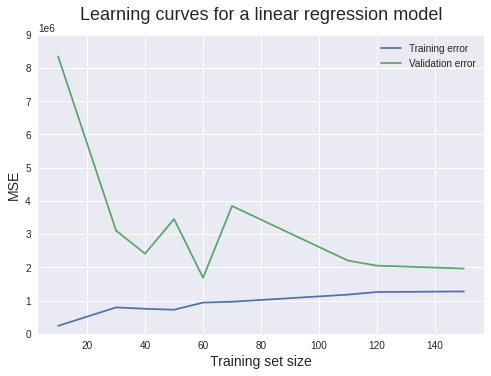

In [25]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')
plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0, 9e+06)
plt.show()

### Grouping data by Day of week

In [26]:
groupby = data.groupby("Day")
days_of_week = {x: groupby.get_group(x) for x in groupby.groups}

### Plot Bicycle traffic per days with Matplotlib

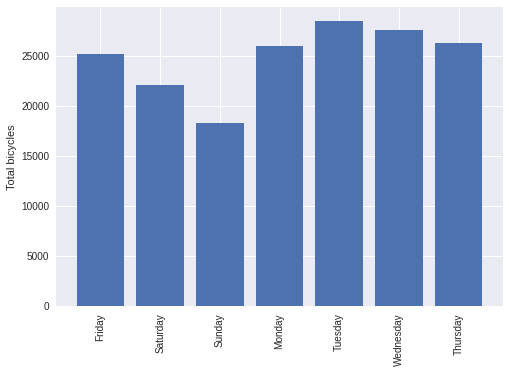

In [27]:
fig, ax = plt.subplots()
ax.bar(data.Day, data["Total"])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Total bicycles')
plt.show()

### Plot Bicycle traffic per days with Plotly

In [28]:
data_agg = data.groupby(by="Day_nr").agg("mean")

trace1 = go.Bar(
      x=data_agg.index,
      y=data_agg.Total,
      name="Day",
      marker=dict(color="rgba(255, 174, 255, 0.5)",
                  line=dict(color='rgb(0, 0, 0)',
                            width=1.5)),
      
)


data_plot = [trace1]
layout = go.Layout(barmode="group")
fig = go.Figure(data=data_plot, layout=layout)
iplot(fig)

In [29]:
data.head()

,Date,Day,HighTemp,LowTemp,Precipitation,Brooklyn Bridge,Manhattan Bridge,Williamsburg Bridge,Queensboro Bridge,Total,NumDay,Month,Day_nr,Month_nr,is_weekend,is_precipitation,is_rainy_month
0,2016-04-01,Friday,78.1,66.0,0.01,1704.0,3126.0,4115.0,2552.0,11497.0,1.0,4,5.0,4.0,0,1,0
1,2016-04-02,Saturday,55.0,48.9,0.15,827.0,1646.0,2565.0,1884.0,6922.0,2.0,4,6.0,4.0,1,1,0
2,2016-04-03,Sunday,39.9,34.0,0.09,526.0,1232.0,1695.0,1306.0,4759.0,3.0,4,7.0,4.0,1,1,0
3,2016-04-04,Monday,44.1,33.1,0.47,521.0,1067.0,1440.0,1307.0,4335.0,4.0,4,1.0,4.0,0,1,0
4,2016-04-05,Tuesday,42.1,26.1,0.00,1416.0,2617.0,3081.0,2357.0,9471.0,5.0,4,2.0,4.0,0,0,0


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date                 214 non-null    datetime64[ns]
 1   Day                  214 non-null    object        
 2   HighTemp             214 non-null    float64       
 3   LowTemp              214 non-null    float64       
 4   Precipitation        214 non-null    float64       
 5   Brooklyn Bridge      214 non-null    float64       
 6   Manhattan Bridge     214 non-null    float64       
 7   Williamsburg Bridge  214 non-null    float64       
 8   Queensboro Bridge    214 non-null    float64       
 9   Total                214 non-null    float64       
 10  NumDay               214 non-null    float64       
 11  Month                214 non-null    int64         
 12  Day_nr               214 non-null    float64       
 13  Month_nr             214 non-null  

# Pandas profiling tool

In [32]:
pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     / 22.0 MB 18.7 MB/s 0:00:02
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 KB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 KB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 35.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 KB 34.3 MB/s eta 0:00:00
  Created wheel for pandas-profiling: filename=pandas_profiling-dev-py2.py3-none-any.whl size=328711 sha256=9f22740e8dc8195516128ce4d26e1b6a74cc39473773f8bbfa3b80651b29703a
  Stored in directory: /tmp/pip-ephem-wheel-cache-c8wvdmtb/wheels/64/b6/85/dfc808b23666a5910371784e349d28818006ff63ed9cfeca59
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27098 sha25

Please restart runtime, then run again and continue

In [31]:
from pandas_profiling import ProfileReport

profile = ProfileReport(data,
                        title="NYC Bicycle",
                        html={'style': {'full_width':
                                        True}},
                        sort=None)
# Save to file
profile.to_file('./report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# **Data visualization**

### Bar plot with bicycle traffic grouped by weekday and weekend

/usr/local/lib/python3.8/dist-packages/seaborn/categorical.py:3717: UserWarning:

The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.



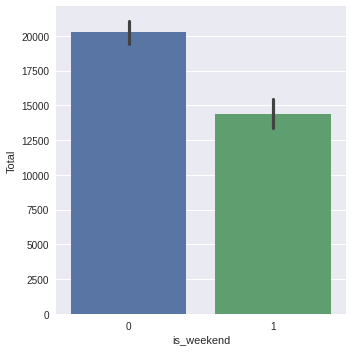

In [32]:
import seaborn as sns
sns.factorplot(x="is_weekend", y="Total", data=data, kind="bar")

### Scatter plot with precipitation

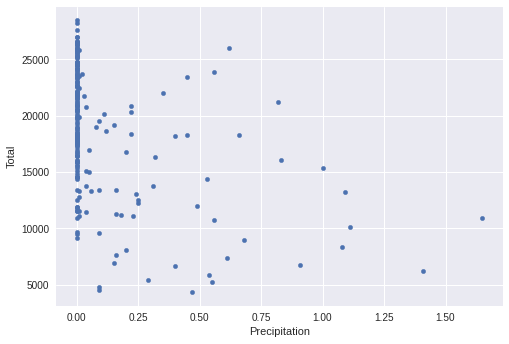

In [33]:
data.plot(x="Precipitation", y="Total", kind="scatter")

In [34]:
data.shape

(214, 17)

### Scatter plot with high temperature

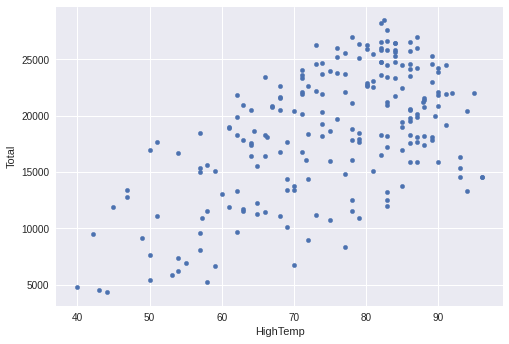

In [35]:
data.plot(x="HighTemp", y="Total", kind="scatter")

### Histograma with traffic grouped by "With Precipitation" and "No Precipitation"

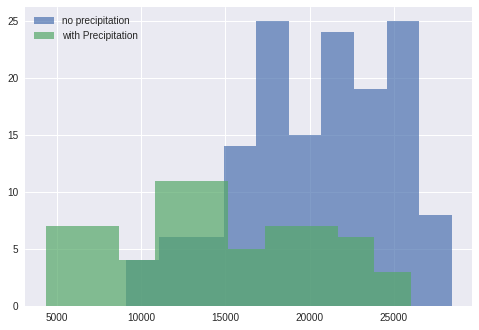

In [36]:
data[data["Precipitation"] == 0]["Total"].hist(alpha = 0.7)
data[data["Precipitation"] > 0]["Total"].hist(alpha = 0.7)
plt.legend(["no precipitation", "with Precipitation"])
plt.show()

### Histogram with Total bicycle traffic by every Bridge and standard deviation

Text(0, 0.5, 'NYC Bicycle mean')

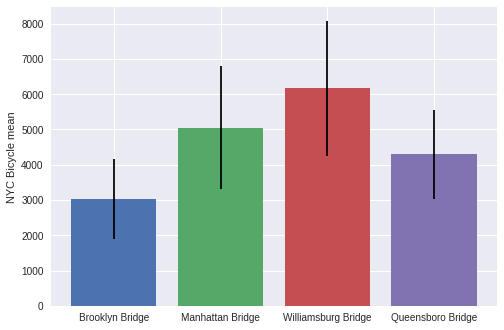

In [37]:
fig, ax = plt.subplots()
ax.bar("Brooklyn Bridge", data["Brooklyn Bridge"].mean(),
       yerr=data["Brooklyn Bridge"].std())
ax.bar("Manhattan Bridge", data["Manhattan Bridge"].mean(),
       yerr=data["Manhattan Bridge"].std())
ax.bar("Williamsburg Bridge", data["Williamsburg Bridge"].mean(),
       yerr=data["Williamsburg Bridge"].std())
ax.bar("Queensboro Bridge", data["Queensboro Bridge"].mean(),
       yerr=data["Queensboro Bridge"].std())
ax.set_ylabel("NYC Bicycle mean")

### Box Plot with Total Bicycle traffic

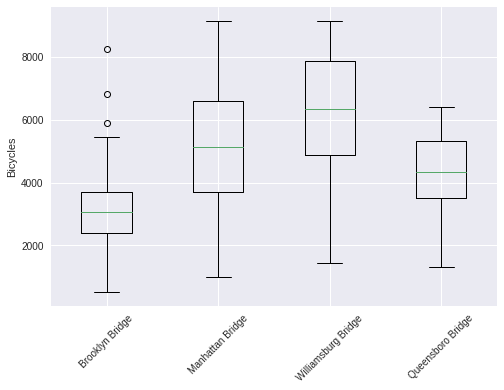

In [38]:
fig, ax = plt.subplots()
ax.boxplot([data["Brooklyn Bridge"],
            data["Manhattan Bridge"],
            data["Williamsburg Bridge"],
            data["Queensboro Bridge"],])
ax.set_xticklabels(["Brooklyn Bridge", "Manhattan Bridge", "Williamsburg Bridge", "Queensboro Bridge"], rotation = 45)
ax.set_ylabel("Bicycles")

plt.show()

### Box Plot - New York City - East River Bicycle Crossings - in weekend vs not in weekend

In [39]:
import plotly.graph_objects as go

x = data["is_weekend"]

fig = go.Figure()

fig.add_trace(go.Box(
    y=data["Brooklyn Bridge"],
    x=x,
    name='Brooklyn Bridge',
    marker_color='#3D9970'
))
fig.add_trace(go.Box(
    y=data["Manhattan Bridge"],
    x=x,
    name='Manhattan Bridge',
    marker_color='#FF4136'
))
fig.add_trace(go.Box(
    y=data["Williamsburg Bridge"],
    x=x,
    name='Williamsburg Bridge',
    marker_color='#FF851B'
))
fig.add_trace(go.Box(
    y=data["Queensboro Bridge"],
    x=x,
    name='Queensboro Bridge',
    marker_color='#17becf'
))

fig.update_layout(
    title='New York City - East River Bicycle Crossings - in weekend vs not in weekend',
    yaxis_title='Bicycles',
    boxmode='group' # group together boxes of the different traces for each value of x
)

fig.show()

Box plot - New York City - East River Bicycle Crossings by every weekday

In [40]:
import plotly.graph_objects as go

x = data["Day_nr"]

fig = go.Figure()

fig.add_trace(go.Box(
    y=data["Brooklyn Bridge"],
    x=x,
    name='Brooklyn Bridge',
    marker_color='#3D9970'
))
fig.add_trace(go.Box(
    y=data["Manhattan Bridge"],
    x=x,
    name='Manhattan Bridge',
    marker_color='#FF4136'
))
fig.add_trace(go.Box(
    y=data["Williamsburg Bridge"],
    x=x,
    name='Williamsburg Bridge',
    marker_color='#FF851B'
))
fig.add_trace(go.Box(
    y=data["Queensboro Bridge"],
    x=x,
    name='Queensboro Bridge',
    marker_color='#17becf'
))

fig.update_layout(
    title='New York City - East River Bicycle Crossings by every weekday',
    yaxis_title='Bicycles',
    boxmode='group' # group together boxes of the different traces for each value of x
)

fig.show()

### Visualizing the correlations:

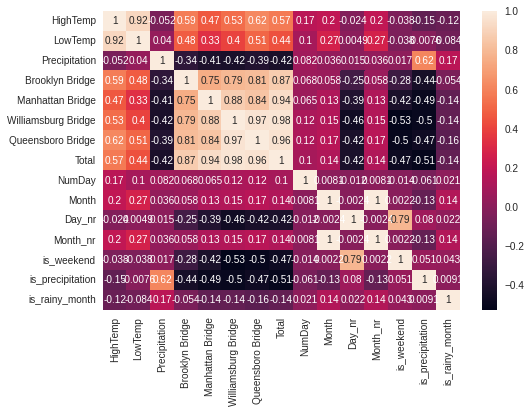

In [41]:
sns.heatmap(data.corr(), annot = True)
plt.show()

The heatmap shows that the number of rides clearly shows a negative correlation with precipitation. We also see a high positive correlation with HighTemp and rides, indicating a correlation. To validate this, lets plot Total Rides with Precipitation. As seen, the number of rides is the more on days when precipitation is 0.



### Lets see the rides across the bridges spread for the month.

In [44]:
trace1 = go.Scatter(
      x=data.Date,
      y=data.HighTemp,
      mode="lines",
      name="HighTemp",
      marker=dict(color="rgba(255, 128, 255, 0.8)"),

)

trace2 = go.Scatter(
      x=data.Date,
      y=data.LowTemp,
      mode="lines",
      name="LowTempDate",
      marker=dict(color="rgba(255, 128, 2, 0.8)"),

)

trace3 = go.Scatter(
      x=data.Date,
      y=data.Precipitation,
      mode="lines",
      name="Precipitation",
      marker=dict(color="rgba(0, 255, 200, 0.8)"),

)
trace4 = go.Scatter(
      x=data.Date,
      y=data["Brooklyn Bridge"],
      mode="lines",
      name="Brooklyn Bridge",
      marker=dict(color='darkturquoise'),
)

trace5 = go.Scatter(
      x=data.Date,
      y=data["Manhattan Bridge"],
      mode="lines",
      name="Manhattan Bridge",
      marker=dict(color='brown'),
)

trace6 = go.Scatter(
      x=data.Date,
      y=data["Williamsburg Bridge"],
      mode="lines",
      name="Williamsburg Bridge",
      marker=dict(color='rgba(140, 86, 75, 0.8)'),
)

trace7 = go.Scatter(
      x=data.Date,
      y=data["Queensboro Bridge"],
      mode="lines",
      name="Queensboro Bridge",
      marker=dict(color='rgba(227, 119, 194, 0.8)'),
)

trace8 = go.Scatter(
      x=data.Date,
      y=data.Total,
      mode="lines",
      name="Total",
      marker=dict(color='rgba(44, 160, 44, 0.8)'),
)

data_evolution = [trace1, trace2, trace3, trace4, trace5, trace6, trace7, trace8]
layout = dict(title="Bicycles rides across the bridges spread for the month",
              xaxis=dict(title="Date", ticklen=5, zeroline=False),
)
fig = dict(data=data_evolution, layout=layout)
iplot(fig)

### Histogram with precipitation per day

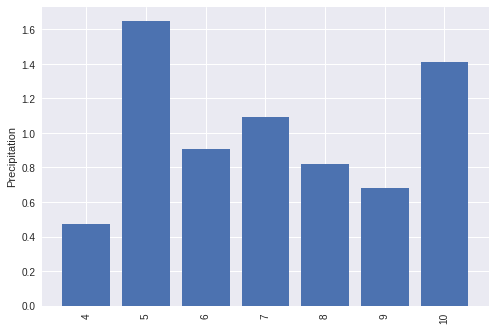

In [45]:
fig, ax = plt.subplots()
ax.bar(data.Month, data["Precipitation"])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Precipitation')
plt.show()

### Histogram with total bicycle rides per days

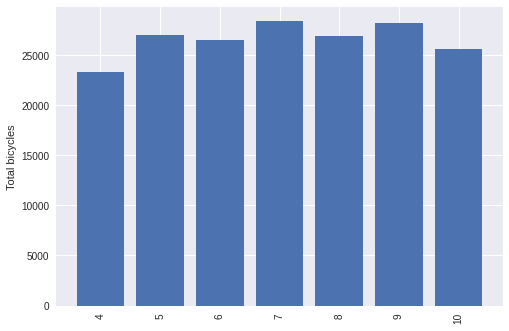

In [46]:
fig, ax = plt.subplots()
ax.bar(data.Month, data["Total"])
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('Total bicycles')
plt.show()


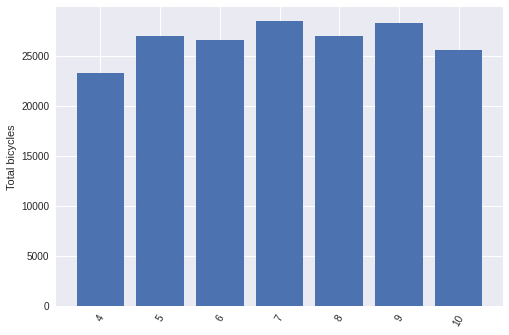

In [47]:
groupby = data.groupby("Month")
days_of_week = {x: groupby.get_group(x) for x in groupby.groups}

fig, ax = plt.subplots()
ax.bar(data.Month, data["Total"])
ax.xaxis.set_tick_params(rotation=60)
ax.set_ylabel('Total bicycles')
plt.show()



### Histogram with mean bicycle rides per days

In [48]:
data_agg = data.groupby(by="Month").agg("mean")

trace1 = go.Bar(
      x=data_agg.index,
      y=data_agg.Total,
      name="Month",
      marker=dict(color="rgba(255, 174, 255, 0.5)",
                  line=dict(color='rgb(0, 0, 0)',
                            width=1.5)),
      
)


data_plot = [trace1]
layout = go.Layout(barmode="group")
fig = go.Figure(data=data_plot, layout=layout)
iplot(fig)

### Histogram mean precipitations per day

In [49]:
data_agg_rainy_month = data.groupby(by="Month").agg("mean")

trace1 = go.Bar(
      x=data_agg.index,
      y=data_agg.Precipitation,
      name="Month",
      marker=dict(color="rgba(255, 174, 255, 0.5)",
                  line=dict(color='rgb(0, 0, 0)',
                            width=1.5)),
      
)


data_plot_rainy_month = [trace1]
layout = go.Layout(barmode="group")
fig = go.Figure(data=data_plot_rainy_month, layout=layout)
iplot(fig)

### Scatter plot comparison with HighTemp, LowTemp and Precipitations

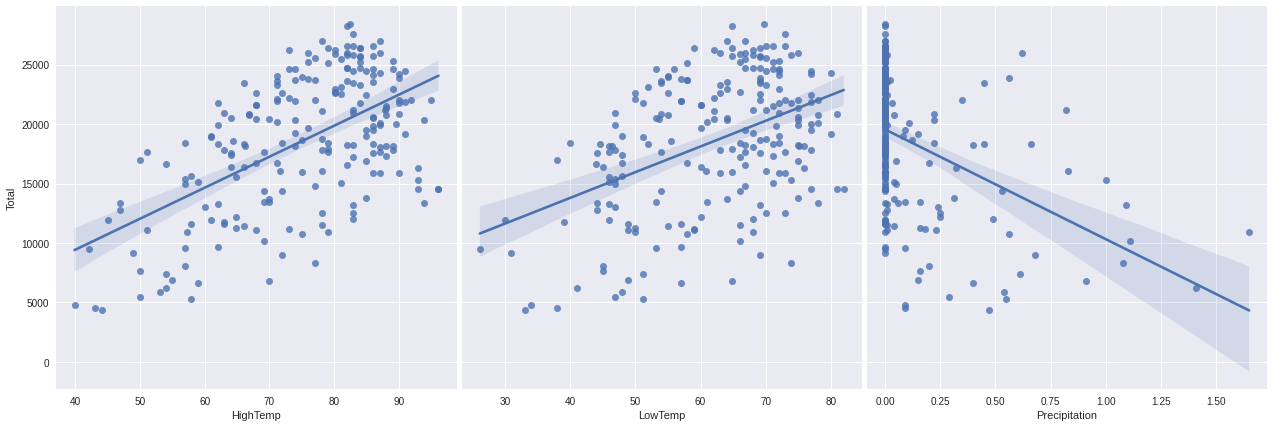

In [52]:
sns.pairplot(data, x_vars=['HighTemp', 'LowTemp', 'Precipitation'], y_vars='Total', kind='reg', height=6)
plt.show()